<a href="https://colab.research.google.com/github/drewwint/robustmlm/blob/main/working_mixed_effects_python_penalty_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I am writing these due to my frustration with statsmodels not implimenting regularization or sandwhich estimator in mixed effects models well and so I am doing the following to try to improve that

In [32]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.optimize import minimize
from scipy.stats import t, normaltest
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import OLSInfluence

import matplotlib.pyplot as plt
import seaborn as sns


## simulating data

In [1]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Parameters for simulation
n = 500                # total number of observations
n_groups = 30          # number of groups
group_ids = np.random.choice(np.arange(1, n_groups+1), size=n, replace=True)

# Simulate covariates
time = np.random.normal(0, 1, n)
cu_sum = np.random.normal(0, 1, n)
sex_rc = np.random.binomial(1, 0.5, n)  # binary indicator
ses = np.random.uniform(-1, 1, n)
nihtbx_totalcomp_fc = np.random.normal(0, 1, n)
site = np.random.choice([1, 2, 3, 4, 5], size=n)  # categorical as numeric levels
mri_serial_num = np.random.normal(0, 1, n)
race_ethnicity = np.random.choice([1, 2, 3, 4], size=n)  # categorical as numeric
siblings_twins = np.random.poisson(1, n)
handedness = np.random.binomial(1, 0.8, n)  # 80% one hand preference
puberty = np.random.normal(0, 1, n)

# Create interaction terms based on the simulated covariates
int_sex_cu = sex_rc * cu_sum
int_sex_time = sex_rc * time
int_cu_time = cu_sum * time
int_sex_cu_time = sex_rc * cu_sum * time

# Fixed effect coefficients (arbitrarily chosen for simulation)
coefficients = {
    "intercept": 2.0,
    "time": 0.5,
    "cu_sum": 1.0,
    "sex_rc": -0.5,
    "ses": 0.3,
    "nihtbx_totalcomp_fc": 0.7,
    "site": 0.2,
    "mri_serial_num": -0.1,
    "race_ethnicity": 0.4,
    "siblings_twins": 0.1,
    "handedness": -0.3,
    "puberty": 0.6,
    "int_sex_cu": 0.8,
    "int_sex_time": -0.2,
    "int_cu_time": 0.3,
    "int_sex_cu_time": -0.4
}

# Generate random intercepts for each group ~ N(0, 1)
group_effects = {g: np.random.normal(0, 1) for g in np.unique(group_ids)}

# Compute the outcome variable as the linear combination of predictors plus a group effect and noise
# Create a DataFrame of predictors first
ddc_dat = pd.DataFrame({
    "id": group_ids,
    "time": time,
    "cu_sum": cu_sum,
    "sex_rc": sex_rc,
    "ses": ses,
    "nihtbx_totalcomp_fc": nihtbx_totalcomp_fc,
    "site": site,
    "mri_serial_num": mri_serial_num,
    "race_ethnicity": race_ethnicity,
    "siblings_twins": siblings_twins,
    "handedness": handedness,
    "puberty": puberty,
    "int_sex_cu": int_sex_cu,
    "int_sex_time": int_sex_time,
    "int_cu_time": int_cu_time,
    "int_sex_cu_time": int_sex_cu_time
})

# Compute the linear predictor for each observation
linear_predictor = (
    coefficients["intercept"] +
    coefficients["time"] * ddc_dat["time"] +
    coefficients["cu_sum"] * ddc_dat["cu_sum"] +
    coefficients["sex_rc"] * ddc_dat["sex_rc"] +
    coefficients["ses"] * ddc_dat["ses"] +
    coefficients["nihtbx_totalcomp_fc"] * ddc_dat["nihtbx_totalcomp_fc"] +
    coefficients["site"] * ddc_dat["site"] +
    coefficients["mri_serial_num"] * ddc_dat["mri_serial_num"] +
    coefficients["race_ethnicity"] * ddc_dat["race_ethnicity"] +
    coefficients["siblings_twins"] * ddc_dat["siblings_twins"] +
    coefficients["handedness"] * ddc_dat["handedness"] +
    coefficients["puberty"] * ddc_dat["puberty"] +
    coefficients["int_sex_cu"] * ddc_dat["int_sex_cu"] +
    coefficients["int_sex_time"] * ddc_dat["int_sex_time"] +
    coefficients["int_cu_time"] * ddc_dat["int_cu_time"] +
    coefficients["int_sex_cu_time"] * ddc_dat["int_sex_cu_time"]
)

# Add the group random effect and some residual noise ~ N(0,1)
ddc_dat["y1"] = linear_predictor + ddc_dat["id"].map(group_effects) + np.random.normal(0, 1, n)

# Define a list of outcome variables (here just one outcome)
all_nodes = ["y1"]

# Show a preview of the simulated dataset
print(ddc_dat.head())
print("\nList of outcome variables (all_nodes):", all_nodes)


   id      time    cu_sum  sex_rc       ses  nihtbx_totalcomp_fc  site  \
0   7 -0.666943  0.227261       0  0.085092            -0.959828     1   
1  20 -1.691818  0.747980       1  0.583400             0.975051     5   
2  29  0.656797  1.005102       0  0.097677             0.470322     5   
3  15 -1.435901 -0.507437       1  0.225800            -1.855838     2   
4  11 -1.183266 -0.329331       0 -0.547706             1.096753     4   

   mri_serial_num  race_ethnicity  siblings_twins  handedness   puberty  \
0        0.401561               3               1           1  0.722827   
1        0.468316               1               1           0  0.111799   
2        0.519999               2               0           1  1.007157   
3       -0.977837               1               1           1  0.517995   
4       -0.682391               2               1           1  0.026205   

   int_sex_cu  int_sex_time  int_cu_time  int_sex_cu_time        y1  
0    0.000000     -0.000000    -0.

In [40]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import t

# -------------------------------
# Vectorized robust (Huber) objective with optional L1 or L2 penalties
# -------------------------------
def vectorized_mixed_model_objective(params, y, X, group_indices, delta=1.0, l2_penalty=None, l1_penalty=None):
    """
    Computes the total loss for a robust mixed model with optional L1 or L2 penalties.

    Parameters:
    -----------
    params : np.ndarray
        Concatenated vector of fixed effects coefficients (beta) and random intercepts (b).
    y : np.ndarray
        Outcome variable (N,).
    X : np.ndarray
        Design matrix for fixed effects (N, p).
    group_indices : np.ndarray
        Array mapping each observation to a random group (N,).
    delta : float
        Threshold parameter for the Huber loss.
    l2_penalty : float or None
        Optional L2 regularization weight on fixed effects (ridge). Default is None.
    l1_penalty : float or None
        Optional L1 regularization weight on fixed effects (lasso). Default is None.

    Returns:
    --------
    loss : float
        The total objective value (Huber loss + regularization).
    """
    p = X.shape[1]
    beta = params[:p]
    b = params[p:]
    preds = X.dot(beta) + b[group_indices]

    residuals = y - preds
    abs_res = np.abs(residuals)
    if delta is None:
        huber_loss = residuals**2
    else:
      huber_loss = np.where(abs_res <= delta, 0.5 * residuals**2, delta * (abs_res - 0.5 * delta))

    loss = np.sum(huber_loss)

    # Add penalties if specified
    if l2_penalty is not None:
        loss += l2_penalty * np.sum(beta**2)
    if l1_penalty is not None:
        loss += l1_penalty * np.sum(np.abs(beta))

    return loss

# -------------------------------
# Fit robust mixed model
# -------------------------------
def fit_mixed_model(y, X, group_indices, delta=1.0, l2_penalty=None, l1_penalty=None):
    """
    Fits a robust linear mixed model with random intercepts and optional L1/L2 regularization.

    Parameters:
    -----------
    y : np.ndarray
        Outcome variable (N,).
    X : np.ndarray
        Fixed effects design matrix (N, p).
    group_indices : np.ndarray
        Integer array mapping each observation to its group (N,).
    delta : float
        Huber loss threshold for robust estimation.
    l2_penalty : float or None
        L2 penalty weight (ridge). Default is None.
    l1_penalty : float or None
        L1 penalty weight (lasso). Default is None.

    Returns:
    --------
    res : scipy.optimize.OptimizeResult
        Optimization result containing estimated parameters and diagnostics.
    """
    p = X.shape[1]
    n_groups = np.max(group_indices) + 1
    initial_params = np.concatenate([np.zeros(p), np.zeros(n_groups)])

    res = minimize(vectorized_mixed_model_objective, initial_params,
                   args=(y, X, group_indices, delta, l2_penalty, l1_penalty),
                   method="BFGS")
    return res

# -------------------------------
# Bootstrap confidence intervals for fixed effects
# -------------------------------
def bootstrap_fixed_effects(y, X, groups, group_indices, B=100, delta=1.0, l2_penalty=None, l1_penalty=None):
    """
    Bootstraps confidence intervals for fixed effects by resampling clusters (groups).

    Parameters:
    -----------
    y : np.ndarray
        Outcome variable (N,).
    X : np.ndarray
        Fixed effects design matrix (N, p).
    groups : np.ndarray
        Original group labels (N,) (e.g., subject IDs).
    group_indices : np.ndarray
        Group index vector matching the internal structure used by the model (N,).
    B : int
        Number of bootstrap iterations.
    delta : float
        Huber loss threshold.
    l2_penalty : float or None
        L2 penalty weight. Default is None.
    l1_penalty : float or None
        L1 penalty weight. Default is None.

    Returns:
    --------
    ci_lower : np.ndarray
        2.5th percentile of bootstrap estimates (p,).
    ci_upper : np.ndarray
        97.5th percentile of bootstrap estimates (p,).
    """
    p = X.shape[1]
    unique_groups = np.unique(groups)
    n_groups = len(unique_groups)
    bootstrap_estimates = []

    for b in range(B):
        sampled_groups = np.random.choice(unique_groups, size=n_groups, replace=True)
        bootstrap_indices = np.concatenate([np.where(groups == g)[0] for g in sampled_groups])

        y_boot = y[bootstrap_indices]
        X_boot = X[bootstrap_indices, :]
        groups_boot = groups[bootstrap_indices]

        # Re-index groups for bootstrapped data
        unique_boot = np.unique(groups_boot)
        group_map_boot = {g: i for i, g in enumerate(unique_boot)}
        group_indices_boot = np.array([group_map_boot[g] for g in groups_boot])

        try:
            res_boot = fit_mixed_model(y_boot, X_boot, group_indices_boot,
                                       delta=delta, l2_penalty=l2_penalty, l1_penalty=l1_penalty)
            beta_boot = res_boot.x[:p]
            bootstrap_estimates.append(beta_boot)
        except:
            continue  # skip iteration if optimization fails

    bootstrap_estimates = np.array(bootstrap_estimates)
    ci_lower = np.percentile(bootstrap_estimates, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_estimates, 97.5, axis=0)
    return ci_lower, ci_upper

# from joblib import Parallel, delayed
# import numpy as np

# def bootstrap_fixed_effects(
#     y, X, groups, group_indices, B=100, delta=1.0, l2_penalty=None, l1_penalty=None, n_jobs=-1
# ):
#     """
#     Faster bootstrap of confidence intervals for fixed effects using parallel processing.

#     Parameters:
#     -----------
#     y : np.ndarray
#         Outcome variable (N,).
#     X : np.ndarray
#         Fixed effects design matrix (N, p).
#     groups : np.ndarray
#         Original group labels (N,).
#     group_indices : np.ndarray
#         Group index vector matching the internal structure used by the model (N,).
#     B : int
#         Number of bootstrap iterations.
#     delta : float
#         Huber loss threshold.
#     l2_penalty : float or None
#         L2 penalty weight.
#     l1_penalty : float or None
#         L1 penalty weight.
#     n_jobs : int
#         Number of parallel jobs (default: -1 uses all CPUs).

#     Returns:
#     --------
#     ci_lower : np.ndarray
#         2.5th percentile of bootstrap estimates (p,).
#     ci_upper : np.ndarray
#         97.5th percentile of bootstrap estimates (p,).
#     """
#     p = X.shape[1]
#     unique_groups = np.unique(groups)
#     n_groups = len(unique_groups)

#     # Pre-cache indices for each group
#     group_to_indices = {g: np.where(groups == g)[0] for g in unique_groups}

#     def one_bootstrap(_):
#         sampled_groups = np.random.choice(unique_groups, size=n_groups, replace=True)
#         bootstrap_indices = np.concatenate([group_to_indices[g] for g in sampled_groups])

#         y_boot = y[bootstrap_indices]
#         X_boot = X[bootstrap_indices, :]
#         groups_boot = groups[bootstrap_indices]

#         # Re-map groups
#         unique_boot = np.unique(groups_boot)
#         group_map = {g: i for i, g in enumerate(unique_boot)}
#         group_indices_boot = np.array([group_map[g] for g in groups_boot])

#         try:
#             res = fit_mixed_model(y_boot, X_boot, group_indices_boot,
#                                   delta=delta, l2_penalty=l2_penalty, l1_penalty=l1_penalty)
#             return res.x[:p]
#         except Exception:
#             return None  # skip failed fits

#     bootstrap_estimates = Parallel(n_jobs=n_jobs)(
#         delayed(one_bootstrap)(b) for b in range(B)
#     )

#     bootstrap_estimates = np.array([b for b in bootstrap_estimates if b is not None])

#     if len(bootstrap_estimates) < B * 0.8:
#         print(f"Warning: Only {len(bootstrap_estimates)} out of {B} bootstraps succeeded.")

#     ci_lower = np.percentile(bootstrap_estimates, 2.5, axis=0)
#     ci_upper = np.percentile(bootstrap_estimates, 97.5, axis=0)

#     return ci_lower, ci_upper



In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy.stats import t, normaltest
import statsmodels.api as sm

def mixed_model_diagnostics(
    data,
    outcome,
    exog_vars,
    group_col,
    delta=1.0,
    l1_penalty=None,
    l2_penalty=None
):
    """
    Generates diagnostic outputs for a robust mixed effects model using Huber loss and optional L1/L2 penalties.

    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset containing all variables.
    outcome : str
        Name of the dependent (outcome) variable.
    exog_vars : list of str
        List of column names used as fixed effect predictors.
    group_col : str
        Column name used for group-level random intercepts.
    delta : float, optional (default=1.0)
        Delta parameter for Huber loss.
    l1_penalty : float or None, optional (default=None)
        L1 regularization strength. If None, no L1 penalty is used.
    l2_penalty : float or None, optional (default=None)
        L2 regularization strength. If None, no L2 penalty is used.

    Returns:
    --------
    diagnostics : dict
        Dictionary with:
            - 'het_white': DataFrame with White test result.
            - 'convergence': Boolean indicating model convergence.
            - 'outlier_cases': List of identified outlier IDs.
            - 'exogeneity': Description of exogeneity assumption.
            - 'plots': Matplotlib figures for residuals, fitted vs residual, and outlier diagnostics.
    """
    print("="*60)
    print(f"Running Diagnostics for Outcome: {outcome}")
    print("="*60)

    # Prepare inputs
    y = data[outcome].values
    X = sm.add_constant(data[exog_vars])
    X_matrix = X.values
    groups = data[group_col].values
    unique_groups = np.unique(groups)
    group_indices = np.array([np.where(unique_groups == g)[0][0] for g in groups])

    # Fit the model
    res = fit_mixed_model(y, X_matrix, group_indices, delta=delta, l1_penalty=l1_penalty, l2_penalty=l2_penalty)
    beta = res.x[:X_matrix.shape[1]]
    random_effects = res.x[X_matrix.shape[1]:]
    residuals = y - (X_matrix @ beta + random_effects[group_indices])
    ols_model = sm.OLS(residuals, X_matrix).fit()

    # --- Convergence ---
    converged = res.success

    # --- Model info ---
    model_info = {
        "Outcome": outcome,
        "N_observations": len(data),
        "N_groups": len(unique_groups),
        "Group sizes (mean)": np.mean(pd.Series(groups).value_counts()),
        "N_fixed_effects": X_matrix.shape[1],
        "Converged": converged,
        "Loss used": "Huber" if delta is not None else "OLS",
        "L1_penalty": l1_penalty if l1_penalty is not None else "Not used",
        "L2_penalty": l2_penalty if l2_penalty is not None else "Not used",
    }

    print("\n--- Model Information ---")
    for k, v in model_info.items():
        print(f"{k}: {v}")

    # --- White test for heteroskedasticity ---
    white_test = het_white(ols_model.resid, ols_model.model.exog)
    labels = ['Test Statistic', 'Test p-value', 'F-Statistic', 'F-Test p-value']
    het_white_df = pd.DataFrame({ "White Test": labels, "Value": white_test }).set_index("White Test")

    print("\n--- Heteroskedasticity Test (White) ---")
    for idx, row in het_white_df.iterrows():
        print(f"{idx}: {row['Value']:.4f}")

    # --- Outliers using Cook's distance ---
    influence = OLSInfluence(ols_model)
    cooks_d = influence.cooks_distance[0]
    threshold = 4 / (len(y) / np.mean(pd.Series(groups).value_counts()))
    outlier_indices = np.where(cooks_d > threshold)[0]
    outlier_ids = list(set(groups[outlier_indices]))  # Unique IDs only
    outlier_ids = np.array(outlier_ids).tolist()

    print("\n--- Outlier Detection (Cook's Distance) ---")
    print(f"Outlier criteria = 4/{(len(y) / np.mean(pd.Series(groups).value_counts())):.0f}")
    print(f"Outlier threshold = {threshold:.4f}")
    if outlier_ids:
        print(f"Number of Outlier Cases: {len(outlier_ids)}")
        print(f"Identified Outlier Cases (by grouping variable): {outlier_ids}")
    else:
        print("No outlier cases detected.")

    # --- Residual normality test ---
    norm_test_stat, norm_test_p = normaltest(residuals)
    print("\n--- Residual Normality Test (D’Agostino & Pearson) ---")
    print(f"Test Statistic: {norm_test_stat:.4f}")
    print(f"p-value: {norm_test_p:.4f}")

    # --- Diagnostic plots ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Residuals histogram
    sns.histplot(residuals, kde=True, ax=axs[0])
    axs[0].set_title("Residual Distribution")

    # Residual vs fitted
    fitted_vals = ols_model.fittedvalues
    sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red'}, ax=axs[1])
    axs[1].set_xlabel("Fitted values")
    axs[1].set_ylabel("Residuals")
    axs[1].set_title("Residuals vs. Fitted Values")

    # Cook's distance plot
    axs[2].stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",", basefmt=" ")
    axs[2].axhline(threshold, color='red', linestyle='--')
    for idx in outlier_indices:
        axs[2].text(idx, cooks_d[idx], str(groups[idx]), fontsize=8)
    axs[2].set_title("Cook's Distance with Outliers")

    plt.tight_layout()

    print("\n--- Diagnostic Figures ---")

    plt.show()

    return {
        "model_info": pd.DataFrame(model_info, index=[0]).T,
        "het_white": het_white_df,
        "convergence": converged,
        "outlier_cases": np.array(outlier_ids).tolist(),
        "residual normality": pd.DataFrame({
            "Test Statistic": [norm_test_stat],
            "Test p-value": [norm_test_p]
        }).T,
        "plots": fig
    }




Running Diagnostics for Outcome: y1

--- Model Information ---
Outcome: y1
N_observations: 500
N_groups: 30
Group sizes (mean): 16.666666666666668
N_fixed_effects: 16
Converged: True
Loss used: Huber
L1_penalty: Not used
L2_penalty: Not used

--- Heteroskedasticity Test (White) ---
Test Statistic: 103.0443
Test p-value: 0.7996
F-Statistic: 0.8571
F-Test p-value: 0.8381

--- Outlier Detection (Cook's Distance) ---
Outlier criteria = 4/30
Outlier threshold = 0.1333
No outlier cases detected.

--- Residual Normality Test (D’Agostino & Pearson) ---
Test Statistic: 0.1733
p-value: 0.9170

--- Diagnostic Figures ---


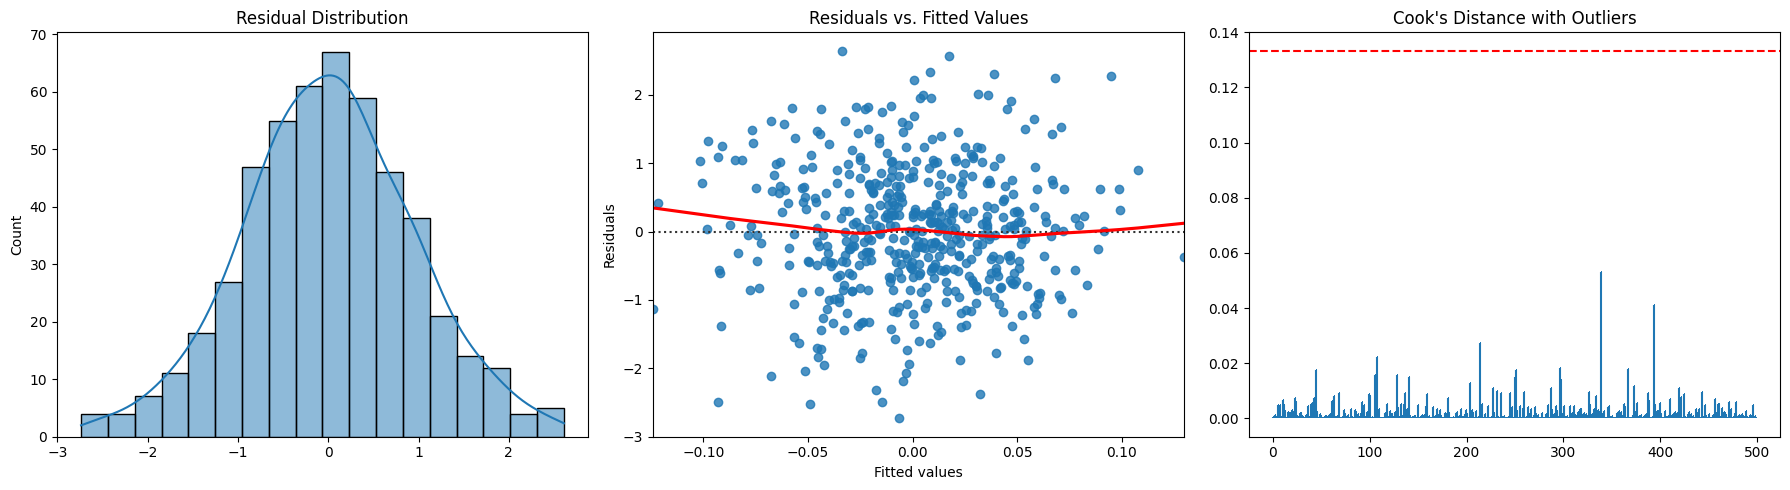

In [46]:
diagnostics = mixed_model_diagnostics(
    ddc_dat,
    outcome="y1",
    # delta=None,
    # l2_penalty = 0.1,
    # l1_penalty = 0.1,
    exog_vars= ["time",
                "cu_sum",
                "sex_rc",
                "ses",
                "nihtbx_totalcomp_fc",
                "site",
                "mri_serial_num",
                "race_ethnicity",
                "siblings_twins",
                "handedness",
                "puberty",
                "int_sex_cu",
                "int_sex_time",
                "int_cu_time",
                "int_sex_cu_time"
                ],
    group_col="id"
    )

In [6]:
diagnostics['outlier_cases']

[1, 2, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 29, 30]

In [41]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import t
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

def robust_mixed_model_pipeline(y_name, data, group_col, fixed_covs, delta=1.0, l2_penalty=None, l1_penalty=None, B=100):
    """
    Fit a robust linear mixed-effects model with optional L1 (lasso) and L2 (ridge) regularization.

    This function estimates fixed effects, random effects, robust standard errors,
    and bootstrapped confidence intervals for a mixed-effects model using Huber loss
    for robustness to outliers. Both L1 and L2 penalties are supported for shrinkage regularization.
    Additionally, it prints model summary information and returns a tidy results DataFrame.

    Parameters
    ----------
    y_name : str
        Name of the dependent variable column in the data.

    data : pandas.DataFrame
        A DataFrame containing all variables used in the model, including the outcome,
        fixed covariates, and grouping variable.

    group_col : str
        Name of the column in `data` that defines the grouping variable (random intercepts).

    fixed_covs : list of str
        A list of column names to be used as fixed effect predictors.

    delta : float, optional (default=1.0)
        Robustness parameter for the Huber loss function. Smaller values give more
        weight to outlier robustness. If set to None, standard OLS loss is used.

    l2_penalty : float or None, optional (default=None)
        L2 regularization (ridge) penalty. If None, no L2 penalty is applied.

    l1_penalty : float or None, optional (default=None)
        L1 regularization (lasso) penalty. If None, no L1 penalty is applied.

    B : int, optional (default=100)
        Number of bootstrap samples used to compute confidence intervals.

    Returns
    -------
    results_df : pandas.DataFrame
        A DataFrame with the following columns:
        - 'params': Names of fixed effects, plus random effect summary and R² metrics.
        - 'beta_unstd': Unstandardized estimated coefficients.
        - 'beta_std': Standardized estimated coefficients (based on z-scoring X and y).
        - 'SE': Approximate standard errors based on residual variance and penalty-adjusted X'X.
        - 't': t-statistics for the fixed effects.
        - 'p': Two-tailed p-values for fixed effects.
        - 'CI_lower': Lower bound of the bootstrapped 95% confidence interval.
        - 'CI_upper': Upper bound of the bootstrapped 95% confidence interval.
    """
    print("="*60)
    print(f"Running Pipeline for Outcome: {y_name}")
    print("="*60)

    # Prepare data
    y = data[y_name].values
    X = sm.add_constant(data[fixed_covs])
    X_matrix = X.values
    groups = data[group_col].values
    unique_groups = np.unique(groups)
    group_indices = np.array([np.where(unique_groups == g)[0][0] for g in groups])

    # Fit model (unstandardized)
    res = fit_mixed_model(y, X_matrix, group_indices, delta=delta, l2_penalty=l2_penalty, l1_penalty=l1_penalty)
    converged = res.success
    beta = res.x[:X_matrix.shape[1]]
    random_effects = res.x[X_matrix.shape[1]:]

    # Fit model (standardized)
    X_std = StandardScaler().fit_transform(X_matrix)
    y_std = (y - y.mean()) / y.std()
    res_std = fit_mixed_model(y_std, X_std, group_indices, delta=delta, l2_penalty=l2_penalty, l1_penalty=l1_penalty)
    std_beta = res_std.x[:X_matrix.shape[1]]

    # Residuals and SEs
    preds = X_matrix @ beta + random_effects[group_indices]
    residuals = y - preds
    dof = len(y) - len(beta)
    residual_var = np.var(residuals, ddof=len(beta))
    XTX = X_matrix.T @ X_matrix
    if l2_penalty is not None:
      ridge_term = l2_penalty * np.eye(X_matrix.shape[1])
    else:
      ridge_term = 0
    XTX_inv = np.linalg.inv(XTX + ridge_term)
    se_beta = np.sqrt(np.diag(residual_var * XTX_inv))
    t_values = beta / se_beta
    p_values = 2 * t.sf(np.abs(t_values), df=dof)

    # Bootstrap confidence intervals
    ci_lower, ci_upper = bootstrap_fixed_effects(
        y, X_matrix, groups, group_indices,
        B=B, delta=delta, l2_penalty=l2_penalty, l1_penalty=l1_penalty
    )

    # R² values
    var_fixed = np.var(X_matrix @ beta)
    var_random = np.var(random_effects[group_indices])
    var_total = var_fixed + var_random + residual_var
    R2_marginal = var_fixed / var_total
    R2_conditional = (var_fixed + var_random) / var_total

    # --- Model info ---
    model_info = {
        "Outcome": y_name,
        "N_observations": len(data),
        "N_groups": len(unique_groups),
        "Group sizes (mean)": np.mean(pd.Series(groups).value_counts()),
        "N_fixed_effects": X_matrix.shape[1],
        "Converged": converged,
        "Loss used": "Huber" if delta is not None else "OLS",
        "L1_penalty": l1_penalty if l1_penalty is not None else "Not used",
        "L2_penalty": l2_penalty if l2_penalty is not None else "Not used",
    }

    print("\n      ------- Model Information -------")
    for k, v in model_info.items():
        print(f"          {k}: {v}")
    print("     -------------------------------------\n")

    # Results DataFrame
    results_df = pd.DataFrame({
        "params": X.columns,
        "beta_unstd": beta,
        "beta_std": std_beta,
        "SE": se_beta,
        "t": t_values,
        "p": p_values,
        "CI_lower": ci_lower,
        "CI_upper": ci_upper
    })

    # Append random effects summary
    results_df = pd.concat([results_df,
        pd.DataFrame({
            "params": ["random_effects"],
            "beta_unstd": [np.mean(random_effects)],
            "beta_std": [(np.mean(random_effects) / np.std(random_effects)) if np.std(random_effects) > 0 else np.nan],
            "SE": [np.std(random_effects)],
            "t": [np.nan],
            "p": [np.nan],
            "CI_lower": [np.nan],
            "CI_upper": [np.nan]
        })], ignore_index=True)

    # Append R² values
    results_df = pd.concat([results_df,
        pd.DataFrame({
            "params": ["R2_marginal", "R2_conditional"],
            "beta_unstd": [R2_marginal, R2_conditional],
            "beta_std": [np.nan, np.nan],
            "SE": [np.nan, np.nan],
            "t": [np.nan, np.nan],
            "p": [np.nan, np.nan],
            "CI_lower": [np.nan, np.nan],
            "CI_upper": [np.nan, np.nan]
        })], ignore_index=True)


    return round(results_df,4)


In [42]:
fixed_covariates = [
    "time", "cu_sum", "sex_rc", "ses", "nihtbx_totalcomp_fc", "site",
    "mri_serial_num", "race_ethnicity", "siblings_twins", "handedness", "puberty",
    "int_sex_cu", "int_sex_time", "int_cu_time", "int_sex_cu_time"
]

results = robust_mixed_model_pipeline(
    y_name="y1",
    data=ddc_dat,
    group_col="id",
    fixed_covs=fixed_covariates,
    delta=1.0,
    l1_penalty=0.1,
    l2_penalty=0.1,
    B=100  # number of bootstrap iterations
)

print(results)


Running Pipeline for Outcome: y1

      ------- Model Information -------
          Outcome: y1
          N_observations: 500
          N_groups: 30
          Group sizes (mean): 16.666666666666668
          N_fixed_effects: 16
          Converged: False
          Loss used: Huber
          L1_penalty: 0.1
          L2_penalty: 0.1
     -------------------------------------

                 params  beta_unstd  beta_std      SE        t       p  \
0                 const     -0.0000   -0.0000  0.1760  -0.0000  1.0000   
1                  time      0.5043    0.2373  0.0573   8.8015  0.0000   
2                cu_sum      0.9328    0.4165  0.0603  15.4581  0.0000   
3                sex_rc     -0.4356   -0.1031  0.0884  -4.9288  0.0000   
4                   ses      0.1827    0.0534  0.0737   2.4788  0.0135   
5   nihtbx_totalcomp_fc      0.6327    0.2895  0.0426  14.8674  0.0000   
6                  site      0.2051    0.1277  0.0307   6.6803  0.0000   
7        mri_serial_num     -0

In [ ]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from scipy.optimize import minimize
# from scipy.stats import t

# # -------------------------------
# # Define a vectorized robust objective function
# # -------------------------------
# def vectorized_mixed_model_objective(params, y, X, group_indices, delta=1.0, l2_penalty=1.0):
#     """
#     Computes the sum of Huber losses (robust loss) plus an L2 penalty on fixed effects.
#     params: concatenated fixed effects (first p elements) and random intercepts.
#     group_indices: integer indices mapping each observation to its random intercept.
#     """
#     p = X.shape[1]
#     beta = params[:p]
#     b = params[p:]

#     # Vectorized prediction: fixed effects plus random intercept for each observation
#     preds = X.dot(beta) + b[group_indices]

#     # Compute residuals and then Huber loss
#     residuals = y - preds
#     abs_res = np.abs(residuals)
#     loss_vector = np.where(abs_res <= delta, 0.5 * residuals**2, delta * (abs_res - 0.5 * delta))
#     loss = np.sum(loss_vector)

#     # L2 penalty on the fixed effects
#     penalty = l2_penalty * np.sum(beta**2)
#     return loss + penalty

# # -------------------------------
# # Define a function to fit the model for one outcome
# # -------------------------------
# def fit_mixed_model(y, X, group_indices, delta=1.0, l2_penalty=1.0):
#     p = X.shape[1]
#     # Number of groups is assumed to be the maximum index + 1 (0-indexed)
#     n_groups = np.max(group_indices) + 1
#     initial_params = np.concatenate([np.zeros(p), np.zeros(n_groups)])

#     res = minimize(vectorized_mixed_model_objective, initial_params,
#                    args=(y, X, group_indices, delta, l2_penalty),
#                    method="BFGS")
#     return res

# # -------------------------------
# # Define a bootstrap routine to get CIs for fixed effects
# # (Resampling is done by clusters to preserve the grouping structure)
# # -------------------------------
# def bootstrap_fixed_effects(y, X, groups, group_indices, B=100, delta=1.0, l2_penalty=0.1):
#     p = X.shape[1]
#     unique_groups = np.unique(groups)
#     n_groups = len(unique_groups)
#     bootstrap_estimates = []

#     for b in range(B):
#         # Sample groups with replacement
#         sampled_groups = np.random.choice(unique_groups, size=n_groups, replace=True)
#         bootstrap_indices = []
#         for grp in sampled_groups:
#             indices = np.where(groups == grp)[0]
#             bootstrap_indices.extend(indices)
#         bootstrap_indices = np.array(bootstrap_indices)

#         y_boot = y[bootstrap_indices]
#         X_boot = X[bootstrap_indices, :]
#         groups_boot = groups[bootstrap_indices]
#         # Reassign group indices for the bootstrap sample
#         unique_boot = np.unique(groups_boot)
#         group_map_boot = {g: i for i, g in enumerate(unique_boot)}
#         group_indices_boot = np.array([group_map_boot[g] for g in groups_boot])

#         try:
#             res_boot = fit_mixed_model(y_boot, X_boot, group_indices_boot, delta, l2_penalty)
#             beta_boot = res_boot.x[:p]
#             bootstrap_estimates.append(beta_boot)
#         except Exception as e:
#             # Skip iteration if optimization fails.
#             continue
#     bootstrap_estimates = np.array(bootstrap_estimates)
#     # Compute 2.5th and 97.5th percentiles for each fixed effect parameter.
#     ci_lower = np.percentile(bootstrap_estimates, 2.5, axis=0)
#     ci_upper = np.percentile(bootstrap_estimates, 97.5, axis=0)
#     return ci_lower, ci_upper


In [23]:
# import numpy as np
# import pandas as pd
# from scipy.optimize import minimize
# from scipy.stats import t
# from sklearn.preprocessing import StandardScaler
# import statsmodels.api as sm

# def run_robust_l2_mixed_model_pipeline(y_name, data, group_col, fixed_covs, delta=1.0, l2_penalty=0.1, B=100):
#     # Prepare data
#     y = data[y_name].values
#     X = sm.add_constant(data[fixed_covs])
#     X_matrix = X.values
#     groups = data[group_col].values
#     unique_groups = np.unique(groups)
#     group_indices = np.array([np.where(unique_groups == g)[0][0] for g in groups])

#     # Fit model
#     res = fit_mixed_model(y, X_matrix, group_indices, delta=delta, l2_penalty=l2_penalty)
#     beta = res.x[:X_matrix.shape[1]]
#     random_effects = res.x[X_matrix.shape[1]:]

#     # Standardized betas
#     X_std = StandardScaler().fit_transform(X_matrix)
#     y_std = (y - y.mean()) / y.std()
#     res_std = fit_mixed_model(y_std, X_std, group_indices, delta=delta, l2_penalty=l2_penalty)
#     std_beta = res_std.x[:X_matrix.shape[1]]

#     # Approximate residuals for SEs and t-values
#     preds = X_matrix @ beta + random_effects[group_indices]
#     residuals = y - preds
#     dof = len(y) - len(beta)
#     residual_var = np.var(residuals, ddof=len(beta))
#     XTX_inv = np.linalg.inv(X_matrix.T @ X_matrix + l2_penalty * np.eye(X_matrix.shape[1]))
#     se_beta = np.sqrt(np.diag(residual_var * XTX_inv))
#     t_values = beta / se_beta

#     # Approximate p-values (Satterthwaite approximation)
#     p_values = 2 * t.sf(np.abs(t_values), df=dof)

#     # Bootstrap confidence intervals
#     ci_lower, ci_upper = bootstrap_fixed_effects(y, X_matrix, groups, group_indices,
#                                                  B=B, delta=delta, l2_penalty=l2_penalty)

#     # R² values (approximate)
#     var_fixed = np.var(X_matrix @ beta)
#     var_random = np.var(random_effects[group_indices])
#     var_total = var_fixed + var_random + residual_var
#     R2_marginal = var_fixed / var_total
#     R2_conditional = (var_fixed + var_random) / var_total

#     # Build output dataframe
#     results_df = pd.DataFrame({
#         "params": X.columns,
#         "beta_unstd": beta,
#         "beta_std": std_beta,
#         "SE": se_beta,
#         "t": t_values,
#         "p": p_values,
#         "CI_lower": ci_lower,
#         "CI_upper": ci_upper
#     })

#     # Append random effect summary
#     results_df = pd.concat([results_df,
#         pd.DataFrame({
#             "params": ["random_effects"],#, "random_effect_SE"],
#             "beta_unstd": [np.mean(random_effects)],#,np.std(random_effects)]
#             "beta_std": [(np.mean(random_effects)/np.std(random_effects))],#, np.nan],
#             "SE": [np.std(random_effects)],#, np.nan],
#             "t": [np.nan],#, np.nan],
#             "p": [np.nan],#, np.nan],
#             "CI_lower": [np.nan],#,, np.nan],
#             "CI_upper": [np.nan],#, np.nan]
#         })], ignore_index=True)

#     # Append R2 values
#     results_df = pd.concat([results_df,
#         pd.DataFrame({
#             "params": ["R2_marginal", "R2_conditional"],
#             "beta_unstd": [R2_marginal, R2_conditional],
#             "beta_std": [np.nan, np.nan],
#             "SE": [np.nan, np.nan],
#             "t": [np.nan, np.nan],
#             "p": [np.nan, np.nan],
#             "CI_lower": [np.nan, np.nan],
#             "CI_upper": [np.nan, np.nan]
#         })], ignore_index=True)

#     # Append model outcome info
#     results_df = pd.concat([
#         pd.DataFrame({
#             "params": [f"For Outcome: {y_name} ~"],
#             "beta_unstd": ["--"],
#             "beta_std": ["--"],
#             "SE": ["--"],
#             "t": ["--"],
#             "p": ["--"],
#             "CI_lower": ["--"],
#             "CI_upper": ["--"]
#         }), results_df], ignore_index=True)

#     return results_df


In [ ]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm
# from scipy.optimize import minimize
# from scipy.stats import t

# # -------------------------------
# # Define a vectorized robust objective function
# # -------------------------------
# def vectorized_mixed_model_objective(params, y, X, group_indices, delta=1.0, l2_penalty=1.0):
#     """
#     Computes the sum of Huber losses (robust loss) plus an L2 penalty on fixed effects.
#     params: concatenated fixed effects (first p elements) and random intercepts.
#     group_indices: integer indices mapping each observation to its random intercept.
#     """
#     p = X.shape[1]
#     beta = params[:p]
#     b = params[p:]

#     # Vectorized prediction: fixed effects plus random intercept for each observation
#     preds = X.dot(beta) + b[group_indices]

#     # Compute residuals and then Huber loss
#     residuals = y - preds
#     abs_res = np.abs(residuals)
#     loss_vector = np.where(abs_res <= delta, 0.5 * residuals**2, delta * (abs_res - 0.5 * delta))
#     loss = np.sum(loss_vector)

#     # L2 penalty on the fixed effects
#     penalty = l2_penalty * np.sum(beta**2)
#     return loss + penalty

# # -------------------------------
# # Define a function to fit the model for one outcome
# # -------------------------------
# def fit_mixed_model(y, X, group_indices, delta=1.0, l2_penalty=1.0):
#     p = X.shape[1]
#     # Number of groups is assumed to be the maximum index + 1 (0-indexed)
#     n_groups = np.max(group_indices) + 1
#     initial_params = np.concatenate([np.zeros(p), np.zeros(n_groups)])

#     res = minimize(vectorized_mixed_model_objective, initial_params,
#                    args=(y, X, group_indices, delta, l2_penalty),
#                    method="BFGS")
#     return res

# # -------------------------------
# # Define a bootstrap routine to get CIs for fixed effects
# # (Resampling is done by clusters to preserve the grouping structure)
# # -------------------------------
# def bootstrap_fixed_effects(y, X, groups, group_indices, B=100, delta=1.0, l2_penalty=0.1):
#     p = X.shape[1]
#     unique_groups = np.unique(groups)
#     n_groups = len(unique_groups)
#     bootstrap_estimates = []

#     for b in range(B):
#         # Sample groups with replacement
#         sampled_groups = np.random.choice(unique_groups, size=n_groups, replace=True)
#         bootstrap_indices = []
#         for grp in sampled_groups:
#             indices = np.where(groups == grp)[0]
#             bootstrap_indices.extend(indices)
#         bootstrap_indices = np.array(bootstrap_indices)

#         y_boot = y[bootstrap_indices]
#         X_boot = X[bootstrap_indices, :]
#         groups_boot = groups[bootstrap_indices]
#         # Reassign group indices for the bootstrap sample
#         unique_boot = np.unique(groups_boot)
#         group_map_boot = {g: i for i, g in enumerate(unique_boot)}
#         group_indices_boot = np.array([group_map_boot[g] for g in groups_boot])

#         try:
#             res_boot = fit_mixed_model(y_boot, X_boot, group_indices_boot, delta, l2_penalty)
#             beta_boot = res_boot.x[:p]
#             bootstrap_estimates.append(beta_boot)
#         except Exception as e:
#             # Skip iteration if optimization fails.
#             continue
#     bootstrap_estimates = np.array(bootstrap_estimates)
#     # Compute 2.5th and 97.5th percentiles for each fixed effect parameter.
#     ci_lower = np.percentile(bootstrap_estimates, 2.5, axis=0)
#     ci_upper = np.percentile(bootstrap_estimates, 97.5, axis=0)
#     return ci_lower, ci_upper

# # -------------------------------
# # Example: Fitting one outcome from your data
# # -------------------------------
# # Assume ddc_dat is your DataFrame, all_nodes is a list of outcome column names,
# # and the covariates below match the model specification you provided.
# covariates = [
#     "time",
#     "cu_sum",
#     "sex_rc",
#     "ses",
#     "nihtbx_totalcomp_fc",
#     "site",
#     "mri_serial_num",
#     "race_ethnicity",
#     "siblings_twins",
#     "handedness",
#     "puberty",
#     "int_sex_cu",
#     "int_sex_time",
#     "int_cu_time",
#     "int_sex_cu_time"
# ]

# # For this example, we show one outcome:
# outcome = all_nodes[0]  # e.g., first node in your list
# y = ddc_dat[outcome].values
# X = sm.add_constant(ddc_dat[covariates]).values  # include intercept
# groups = ddc_dat["id"].values

# # Create integer mapping for groups
# unique_groups = np.sort(np.unique(groups))
# group_map = {g: i for i, g in enumerate(unique_groups)}
# group_indices = np.array([group_map[g] for g in groups])

# # Tuning parameters for the robust loss and regularization
# delta = 1.0
# l2_penalty = 0.1

# # Fit the model
# res = fit_mixed_model(y, X, group_indices, delta, l2_penalty)
# p_fixed = X.shape[1]
# fixed_beta = res.x[:p_fixed]
# random_intercepts = res.x[p_fixed:]

# # -------------------------------
# # Compute standard errors, t-values and p-values for fixed effects.
# # (Here we use the inverse Hessian approximation from BFGS.)
# # -------------------------------
# # Note: The hess_inv from BFGS is an approximation to the inverse Hessian matrix.
# hess_inv = res.hess_inv
# se_all = np.sqrt(np.diag(hess_inv))
# se_fixed = se_all[:p_fixed]

# # For degrees-of-freedom, we approximate using the number of clusters minus one
# df = len(unique_groups) - 1
# t_values = fixed_beta / se_fixed
# p_values = 2 * (1 - t.cdf(np.abs(t_values), df))

# # -------------------------------
# # Compute standardized beta estimates.
# # Standardized beta = unstandardized beta * (std(X) / std(y))
# # For the constant term, standardized beta is not defined (set as NaN).
# # -------------------------------
# std_y = np.std(y, ddof=1)
# std_X = np.std(X, axis=0, ddof=1)
# standardized_beta = []
# for i in range(p_fixed):
#     if i == 0:  # constant
#         standardized_beta.append(np.nan)
#     else:
#         standardized_beta.append(fixed_beta[i] * (std_X[i] / std_y))
# standardized_beta = np.array(standardized_beta)

# # -------------------------------
# # Compute bootstrapped confidence intervals (95%) for the unstandardized fixed effects.
# # -------------------------------
# ci_lower, ci_upper = bootstrap_fixed_effects(y, X, groups, group_indices, B=100, delta=delta, l2_penalty=l2_penalty)

# # -------------------------------
# # Compute marginal and conditional R².
# # Marginal R²: Var(fixed predictions)/Var(y)
# # Conditional R²: Var(full predictions)/Var(y)
# # -------------------------------
# fitted_fixed = X.dot(fixed_beta)
# # Get the random intercept contribution per observation.
# fitted_random = np.array([random_intercepts[group_map[g]] for g in groups])
# fitted_full = fitted_fixed + fitted_random
# var_y = np.var(y, ddof=1)
# marginal_R2 = np.var(fitted_fixed, ddof=1) / var_y
# conditional_R2 = np.var(fitted_full, ddof=1) / var_y

# # -------------------------------
# # Build the results DataFrame.
# # -------------------------------
# param_names = ["const"] + covariates  # fixed-effect parameter names

# # Create a DataFrame for fixed effects
# df_fixed = pd.DataFrame({
#     "Parameter": param_names,
#     "Unstandardized Beta": fixed_beta,
#     "Standardized Beta": standardized_beta,
#     "SE": se_fixed,
#     "t": t_values,
#     "p": p_values,
#     "CI_lower": ci_lower,
#     "CI_upper": ci_upper
# })

# # Summarize random effects: here we show the mean and standard error across groups.
# rand_mean = np.mean(random_intercepts)
# rand_se = np.std(random_intercepts, ddof=1) / np.sqrt(len(random_intercepts))
# df_random = pd.DataFrame({
#     "Parameter": ["Random Effect (mean)"],
#     "Unstandardized Beta": [rand_mean],
#     "Standardized Beta": [np.nan],
#     "SE": [rand_se],
#     "t": [np.nan],
#     "p": [np.nan],
#     "CI_lower": [np.nan],
#     "CI_upper": [np.nan]
# })

# # Create a row for R² values (marginal / conditional) with no inference columns.
# df_r2 = pd.DataFrame({
#     "Parameter": ["R2 (Marginal / Conditional)"],
#     "Unstandardized Beta": [f"{marginal_R2:.3f} / {conditional_R2:.3f}"],
#     "Standardized Beta": [np.nan],
#     "SE": [np.nan],
#     "t": [np.nan],
#     "p": [np.nan],
#     "CI_lower": [np.nan],
#     "CI_upper": [np.nan]
# })

# # Combine the fixed effects, random effects, and R2 rows into one DataFrame.
# final_df = pd.concat([df_fixed, df_random, df_r2], ignore_index=True)

# # Display the final DataFrame.
# print(final_df)


In [ ]:
# import numpy as np
# import pandas as pd
# from scipy.optimize import minimize
# from scipy.stats import t
# from sklearn.preprocessing import StandardScaler
# import statsmodels.api as sm

# def run_robust_l2_mixed_model_pipeline(y_name, data, group_col, fixed_covs, delta=1.0, l2_penalty=0.1, B=100):
#     # Prepare data
#     y = data[y_name].values
#     X = sm.add_constant(data[fixed_covs])
#     X_matrix = X.values
#     groups = data[group_col].values
#     unique_groups = np.unique(groups)
#     group_indices = np.array([np.where(unique_groups == g)[0][0] for g in groups])

#     # Fit model
#     res = fit_mixed_model(y, X_matrix, group_indices, delta=delta, l2_penalty=l2_penalty)
#     beta = res.x[:X_matrix.shape[1]]
#     random_effects = res.x[X_matrix.shape[1]:]

#     # Standardized betas
#     X_std = StandardScaler().fit_transform(X_matrix)
#     y_std = (y - y.mean()) / y.std()
#     res_std = fit_mixed_model(y_std, X_std, group_indices, delta=delta, l2_penalty=l2_penalty)
#     std_beta = res_std.x[:X_matrix.shape[1]]

#     # Approximate residuals for SEs and t-values
#     preds = X_matrix @ beta + random_effects[group_indices]
#     residuals = y - preds
#     dof = len(y) - len(beta)
#     residual_var = np.var(residuals, ddof=len(beta))
#     XTX_inv = np.linalg.inv(X_matrix.T @ X_matrix + l2_penalty * np.eye(X_matrix.shape[1]))
#     se_beta = np.sqrt(np.diag(residual_var * XTX_inv))
#     t_values = beta / se_beta

#     # Approximate p-values (Satterthwaite approximation)
#     p_values = 2 * t.sf(np.abs(t_values), df=dof)

#     # Bootstrap confidence intervals
#     ci_lower, ci_upper = bootstrap_fixed_effects(y, X_matrix, groups, group_indices,
#                                                  B=B, delta=delta, l2_penalty=l2_penalty)

#     # R² values (approximate)
#     var_fixed = np.var(X_matrix @ beta)
#     var_random = np.var(random_effects[group_indices])
#     var_total = var_fixed + var_random + residual_var
#     R2_marginal = var_fixed / var_total
#     R2_conditional = (var_fixed + var_random) / var_total

#     # Build output dataframe
#     results_df = pd.DataFrame({
#         "params": X.columns,
#         "beta_unstd": beta,
#         "beta_std": std_beta,
#         "SE": se_beta,
#         "t": t_values,
#         "p": p_values,
#         "CI_lower": ci_lower,
#         "CI_upper": ci_upper
#     })

#     # Append random effect summary
#     results_df = pd.concat([results_df,
#         pd.DataFrame({
#             "params": ["random_effects"],#, "random_effect_SE"],
#             "beta_unstd": [np.mean(random_effects)],#,np.std(random_effects)]
#             "beta_std": [(np.mean(random_effects)/np.std(random_effects))],#, np.nan],
#             "SE": [np.std(random_effects)],#, np.nan],
#             "t": [np.nan],#, np.nan],
#             "p": [np.nan],#, np.nan],
#             "CI_lower": [np.nan],#,, np.nan],
#             "CI_upper": [np.nan],#, np.nan]
#         })], ignore_index=True)

#     # Append R2 values
#     results_df = pd.concat([results_df,
#         pd.DataFrame({
#             "params": ["R2_marginal", "R2_conditional"],
#             "beta_unstd": [R2_marginal, R2_conditional],
#             "beta_std": [np.nan, np.nan],
#             "SE": [np.nan, np.nan],
#             "t": [np.nan, np.nan],
#             "p": [np.nan, np.nan],
#             "CI_lower": [np.nan, np.nan],
#             "CI_upper": [np.nan, np.nan]
#         })], ignore_index=True)

#     # Append model outcome info
#     results_df = pd.concat([#results_df,
#         pd.DataFrame({
#             "params": [f"Outcome: {y_name} ~"],
#             "beta_unstd": ["--"],
#             "beta_std": ["--"],
#             "SE": ["--"],
#             "t": ["--"],
#             "p": ["--"],
#             "CI_lower": ["--"],
#             "CI_upper": ["--"]
#         }), results_df], ignore_index=True)

#     return results_df


In [ ]:
# fixed_covariates = [
#     "time", "cu_sum", "sex_rc", "ses", "nihtbx_totalcomp_fc", "site",
#     "mri_serial_num", "race_ethnicity", "siblings_twins", "handedness", "puberty",
#     "int_sex_cu", "int_sex_time", "int_cu_time", "int_sex_cu_time"
# ]

# results = run_robust_l2_mixed_model_pipeline(
#     y_name="y1",
#     data=ddc_dat,
#     group_col="id",
#     fixed_covs=fixed_covariates,
#     delta=1.0,
#     l2_penalty=0.1,
#     B=100  # number of bootstrap iterations
# )

# print(results)


In [ ]:
# ddc_dat.columns


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.stats import zscore


# class RobustMixedModelResult:
#     def __init__(self, beta, random_effects, X, y, group_indices, groups, loss, convergence, success):
#         self.beta = beta
#         self.random_effects = random_effects
#         self.X = X
#         self.y = y
#         self.group_indices = group_indices
#         self.groups = groups
#         self.fittedvalues = self.predict()
#         self.resid = y - self.fittedvalues
#         self.loss = loss
#         self.convergence = convergence
#         self.success = success
#         self.model_info = {
#             "n_obs": len(y),
#             "n_groups": len(np.unique(groups)),
#             "n_fixed": len(beta),
#             "loss_function": "Huber + L2"
#         }

#     def predict(self, X_new=None, group_indices_new=None):
#         if X_new is None or group_indices_new is None:
#             return self.X @ self.beta + self.random_effects[self.group_indices]
#         else:
#             return X_new @ self.beta + self.random_effects[group_indices_new]

# def fit_mixed_model_with_output(y, X, group_indices, groups, delta=1.0, l2_penalty=1.0):
#     p = X.shape[1]
#     n_groups = np.max(group_indices) + 1
#     initial_params = np.concatenate([np.zeros(p), np.zeros(n_groups)])

#     res = minimize(vectorized_mixed_model_objective, initial_params,
#                    args=(y, X, group_indices, delta, l2_penalty),
#                    method="BFGS")

#     beta = res.x[:p]
#     random_effects = res.x[p:]

#     result = RobustMixedModelResult(
#         beta=beta,
#         random_effects=random_effects,
#         X=X,
#         y=y,
#         group_indices=group_indices,
#         groups=groups,
#         loss=res.fun,
#         convergence=res.status,
#         success=res.success
#     )
#     return result


# class RobustMixedModelResult:
#     def __init__(self, beta, random_effects, X, y, group_indices, groups, loss, convergence, success):
#         self.beta = beta
#         self.random_effects = random_effects
#         self.X = X
#         self.y = y
#         self.group_indices = group_indices
#         self.groups = groups
#         self.fittedvalues = self.predict()
#         self.resid = y - self.fittedvalues
#         self.loss = loss
#         self.convergence = convergence
#         self.success = success
#         self.model_info = {
#             "n_obs": len(y),
#             "n_groups": len(np.unique(groups)),
#             "n_fixed": len(beta),
#             "loss_function": "Huber + L2"
#         }

#         # Diagnostics
#         self._compute_diagnostics()

#     def predict(self, X_new=None, group_indices_new=None):
#         if X_new is None or group_indices_new is None:
#             return self.X @ self.beta + self.random_effects[self.group_indices]
#         else:
#             return X_new @ self.beta + self.random_effects[group_indices_new]

#     def _compute_diagnostics(self):
#         # Standardized residuals
#         self.std_resid = zscore(self.resid)

#         # Hat matrix diagonal (approximation for leverage)
#         H = self.X @ np.linalg.pinv(self.X.T @ self.X) @ self.X.T
#         self.leverage = np.diag(H)

#         # Cook's Distance
#         self.cooks_d = (self.std_resid**2 * self.leverage) / (
#             self.model_info["n_fixed"] * (1 - self.leverage)**2)

#         # Outliers: standardized residuals > |2|
#         self.outliers = np.abs(self.std_resid) > 2

#     def plot_residuals(self):
#         fig, axs = plt.subplots(1, 3, figsize=(18, 5))

#         axs[0].scatter(self.fittedvalues, self.resid)
#         axs[0].axhline(0, color='red', linestyle='--')
#         axs[0].set_title("Residuals vs. Fitted")
#         axs[0].set_xlabel("Fitted values")
#         axs[0].set_ylabel("Residuals")

#         axs[1].hist(self.std_resid, bins=30, edgecolor='k')
#         axs[1].set_title("Histogram of Standardized Residuals")

#         axs[2].scatter(self.leverage, self.cooks_d)
#         axs[2].set_title("Cook's Distance vs. Leverage")
#         axs[2].set_xlabel("Leverage")
#         axs[2].set_ylabel("Cook's Distance")

#         plt.tight_layout()
#         plt.show()

#     def summary(self):
#         print("=" * 50)
#         print("Robust Mixed Model Summary")
#         print("=" * 50)
#         print(f"Fixed Effects Coefficients:\n{pd.Series(self.beta, index=[f'b{i}' for i in range(len(self.beta))])}")
#         print("\nModel Info:")
#         for k, v in self.model_info.items():
#             print(f"  {k}: {v}")
#         print(f"\nConvergence Status: {self.success} (code {self.convergence})")
#         print(f"Loss: {self.loss:.4f}")

#         print("\nInfluence Stats:")
#         print(f"  Max Cook's Distance: {np.max(self.cooks_d):.4f}")
#         print(f"  Outliers (> |2| std. residuals): {np.sum(self.outliers)} / {len(self.resid)}")
#         print("=" * 50)


In [ ]:
# result = fit_mixed_model_with_output(y, X, group_indices, groups)

# # View a textual summary of the model
# result.summary()

# # Plot residual diagnostics
# result.plot_residuals()


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.optimize import minimize
# from scipy.stats import t, zscore
# from statsmodels.stats.diagnostic import het_white
# from statsmodels.api import add_constant
# import warnings
# warnings.filterwarnings("ignore")

# # -------------------------------
# # Vectorized objective function
# # -------------------------------
# def vectorized_mixed_model_objective(params, y, X, group_indices, delta=1.0, l2_penalty=None, l1_penalty=None):
#     p = X.shape[1]
#     beta = params[:p]
#     b = params[p:]
#     preds = X @ beta + b[group_indices]
#     residuals = y - preds
#     abs_res = np.abs(residuals)
#     loss_vector = np.where(abs_res <= delta, 0.5 * residuals**2, delta * (abs_res - 0.5 * delta))
#     loss = np.sum(loss_vector)

#     if l2_penalty is not None:
#         loss += l2_penalty * np.sum(beta**2)
#     if l1_penalty is not None:
#         loss += l1_penalty * np.sum(np.abs(beta))
#     return loss

# # -------------------------------
# # Fit model with diagnostics
# # -------------------------------
# class RobustMixedModelResult:
#     def __init__(self, beta, random_effects, X, y, group_indices, groups, loss, convergence, success, l2_penalty, l1_penalty):
#         self.beta = beta
#         self.random_effects = random_effects
#         self.X = X
#         self.y = y
#         self.group_indices = group_indices
#         self.groups = groups
#         self.fittedvalues = self.predict()
#         self.resid = y - self.fittedvalues
#         self.loss = loss
#         self.convergence = convergence
#         self.success = success
#         self.l2_penalty = l2_penalty
#         self.l1_penalty = l1_penalty

#         self.model_info = {
#             "n_obs": len(y),
#             "n_groups": len(np.unique(groups)),
#             "n_fixed": len(beta),
#             "loss_function": self._loss_label()
#         }

#         self._compute_diagnostics()

#     def _loss_label(self):
#         terms = ["Huber"]
#         if self.l2_penalty: terms.append(f"L2={self.l2_penalty}")
#         if self.l1_penalty: terms.append(f"L1={self.l1_penalty}")
#         return " + ".join(terms)

#     def predict(self, X_new=None, group_indices_new=None):
#         if X_new is None or group_indices_new is None:
#             return self.X @ self.beta + self.random_effects[self.group_indices]
#         else:
#             return X_new @ self.beta + self.random_effects[group_indices_new]

#     def _compute_diagnostics(self):
#         self.std_resid = zscore(self.resid)
#         H = self.X @ np.linalg.pinv(self.X.T @ self.X) @ self.X.T
#         self.leverage = np.diag(H)
#         self.cooks_d = (self.std_resid**2 * self.leverage) / (
#             self.model_info["n_fixed"] * (1 - self.leverage)**2)
#         self.outliers = np.abs(self.std_resid) > 2
#         self.outlier_ids = np.unique(self.groups[self.outliers])

#     def plot_residuals(self):
#         fig, axs = plt.subplots(1, 3, figsize=(18, 5))
#         axs[0].scatter(self.fittedvalues, self.resid)
#         axs[0].axhline(0, color='red', linestyle='--')
#         axs[0].set_title("Residuals vs. Fitted")
#         axs[1].hist(self.std_resid, bins=30, edgecolor='k')
#         axs[1].set_title("Standardized Residuals")
#         axs[2].scatter(self.leverage, self.cooks_d)
#         axs[2].set_title("Cook's Distance vs. Leverage")
#         plt.tight_layout()
#         plt.show()

#     def diagnostics_summary(self):
#         labels = ['LM Stat', 'LM p-value', 'F-stat', 'F-test p-value']
#         het = het_white(self.resid, self.X)
#         het_dict = dict(zip(labels, het))

#         print("=" * 50)
#         print("Diagnostics Summary")
#         print("=" * 50)
#         print(f"White Test for Heteroskedasticity: {het_dict}")
#         print(f"Max Cook’s Distance: {np.max(self.cooks_d):.4f}")
#         print(f"Number of Outlier Observations (> |2| z): {np.sum(self.outliers)}")
#         print(f"Outlier Subject IDs: {list(self.outlier_ids)}")
#         print("=" * 50)

# # -------------------------------
# # Fit model wrapper
# # -------------------------------
# def fit_mixed_model_with_output(y, X, group_indices, groups, delta=1.0, l2_penalty=None, l1_penalty=None):
#     p = X.shape[1]
#     n_groups = np.max(group_indices) + 1
#     initial_params = np.concatenate([np.zeros(p), np.zeros(n_groups)])

#     res = minimize(vectorized_mixed_model_objective, initial_params,
#                    args=(y, X, group_indices, delta, l2_penalty, l1_penalty),
#                    method="BFGS")

#     return RobustMixedModelResult(
#         beta=res.x[:p],
#         random_effects=res.x[p:],
#         X=X, y=y,
#         group_indices=group_indices,
#         groups=groups,
#         loss=res.fun,
#         convergence=res.status,
#         success=res.success,
#         l2_penalty=l2_penalty,
#         l1_penalty=l1_penalty
#     )

# # -------------------------------
# # Bootstrapped confidence intervals
# # -------------------------------
# def bootstrap_fixed_effects(y, X, groups, group_indices, B=100, delta=1.0, l2_penalty=None, l1_penalty=None):
#     p = X.shape[1]
#     unique_groups = np.unique(groups)
#     bootstrap_estimates = []

#     for _ in range(B):
#         sampled = np.random.choice(unique_groups, size=len(unique_groups), replace=True)
#         indices = [i for g in sampled for i in np.where(groups == g)[0]]
#         Xb, yb = X[indices], y[indices]
#         group_b = groups[indices]
#         group_map = {g: i for i, g in enumerate(np.unique(group_b))}
#         group_indices_b = np.array([group_map[g] for g in group_b])

#         try:
#             result = fit_mixed_model_with_output(yb, Xb, group_indices_b, group_b,
#                                                  delta, l2_penalty, l1_penalty)
#             bootstrap_estimates.append(result.beta)
#         except:
#             continue

#     ci = np.percentile(np.vstack(bootstrap_estimates), [2.5, 97.5], axis=0)
#     return ci[0], ci[1]

# # -------------------------------
# # Build Results DataFrame
# # -------------------------------
# def summarize_results(result, ci_lower, ci_upper, X, y, outcome_label):
#     beta = result.beta
#     beta_std = beta * X.std(axis=0) / y.std()
#     dof = len(y) - len(beta)
#     se = np.std(result.resid) / np.sqrt(np.sum(X**2, axis=0))
#     t_vals = beta / se
#     p_vals = 2 * t.sf(np.abs(t_vals), df=dof)

#     df = pd.DataFrame({
#         "param": [f'b{i}' for i in range(len(beta))],
#         "beta": beta,
#         "beta_std": beta_std,
#         "t": t_vals,
#         "p": p_vals,
#         "ci_lower": ci_lower,
#         "ci_upper": ci_upper
#     })

#     # Add random effects summary row
#     re_mean = np.mean(result.random_effects)
#     re_se = np.std(result.random_effects)
#     df.loc[len(df)] = ["random_effect", re_mean, None, None, None, None, None]

#     # Add marginal and conditional R²
#     var_f = np.var(result.fittedvalues)
#     var_e = np.var(result.resid)
#     marginal_r2 = var_f / (var_f + var_e)
#     conditional_r2 = (var_f + np.var(result.random_effects)) / (var_f + var_e + np.var(result.random_effects))
#     df.loc[len(df)] = ["marginal_r2", marginal_r2, None, None, None, None, None]
#     df.loc[len(df)] = ["conditional_r2", conditional_r2, None, None, None, None, None]

#     # Add outcome label
#     df.loc[len(df)] = [f"(outcome: {outcome_label} ~)", None, None, None, None, None, None]

#     return df


In [ ]:
# # Simulate your data or plug in real values
# X = add_constant(np.random.randn(200, 5))
# y = X @ np.array([0.5, -1.2, 0.8, 0.0, 0.3, -0.7]) + np.random.randn(200)
# groups = np.random.randint(0, 20, size=200)
# group_indices = np.array([np.where(np.unique(groups) == g)[0][0] for g in groups])

# # Fit model
# result = fit_mixed_model_with_output(y, X, group_indices, groups, l2_penalty=0.1, l1_penalty=None)

# # Get confidence intervals
# ci_low, ci_high = bootstrap_fixed_effects(y, X, groups, group_indices, B=100)

# # Summarize results in tidy dataframe
# results_df = summarize_results(result, ci_low, ci_high, X, y, outcome_label="example_outcome")

# # Optionally, print and inspect
# print(results_df)

# # Optionally, run diagnostics
# result.diagnostics_summary()
# result.plot_residuals()


In [ ]:
# import numpy as np
# import pandas as pd
# from scipy.optimize import minimize
# from scipy.stats import t
# from sklearn.preprocessing import StandardScaler
# import statsmodels.api as sm
# from statsmodels.stats.diagnostic import het_white
# import matplotlib.pyplot as plt

# # Robust + regularized loss
# def vectorized_mixed_model_objective(params, y, X, group_indices, delta=1.0, l2_penalty=None, l1_penalty=None):
#     p = X.shape[1]
#     beta = params[:p]
#     b = params[p:]
#     preds = X.dot(beta) + b[group_indices]
#     residuals = y - preds
#     abs_res = np.abs(residuals)
#     loss_vector = np.where(abs_res <= delta, 0.5 * residuals**2, delta * (abs_res - 0.5 * delta))
#     loss = np.sum(loss_vector)

#     # Add penalties
#     if l2_penalty:
#         loss += l2_penalty * np.sum(beta**2)
#     if l1_penalty:
#         loss += l1_penalty * np.sum(np.abs(beta))
#     return loss

# # Fit model
# def fit_mixed_model(y, X, group_indices, delta=1.0, l2_penalty=None, l1_penalty=None):
#     p = X.shape[1]
#     n_groups = np.max(group_indices) + 1
#     init_params = np.concatenate([np.zeros(p), np.zeros(n_groups)])
#     res = minimize(vectorized_mixed_model_objective, init_params,
#                    args=(y, X, group_indices, delta, l2_penalty, l1_penalty),
#                    method="BFGS")
#     return res

# # Bootstrap
# def bootstrap_fixed_effects(y, X, groups, group_indices, B=100, delta=1.0, l2_penalty=None, l1_penalty=None):
#     p = X.shape[1]
#     unique_groups = np.unique(groups)
#     bootstrap_estimates = []
#     for _ in range(B):
#         sampled_groups = np.random.choice(unique_groups, size=len(unique_groups), replace=True)
#         bootstrap_idx = np.concatenate([np.where(groups == g)[0] for g in sampled_groups])
#         y_boot = y[bootstrap_idx]
#         X_boot = X[bootstrap_idx, :]
#         groups_boot = groups[bootstrap_idx]
#         unique_boot = np.unique(groups_boot)
#         group_map_boot = {g: i for i, g in enumerate(unique_boot)}
#         group_indices_boot = np.array([group_map_boot[g] for g in groups_boot])
#         try:
#             res = fit_mixed_model(y_boot, X_boot, group_indices_boot, delta, l2_penalty, l1_penalty)
#             beta_boot = res.x[:p]
#             bootstrap_estimates.append(beta_boot)
#         except:
#             continue
#     bootstrap_estimates = np.array(bootstrap_estimates)
#     return np.percentile(bootstrap_estimates, 2.5, axis=0), np.percentile(bootstrap_estimates, 97.5, axis=0)

# # Main model wrapper
# def run_robust_mixed_model_pipeline(y_name, data, group_col, fixed_covs, delta=1.0, l2_penalty=None, l1_penalty=None, B=100):
#     y = data[y_name].values
#     X = sm.add_constant(data[fixed_covs])
#     X_matrix = X.values
#     groups = data[group_col].values
#     unique_groups = np.unique(groups)
#     group_indices = np.array([np.where(unique_groups == g)[0][0] for g in groups])

#     res = fit_mixed_model(y, X_matrix, group_indices, delta, l2_penalty, l1_penalty)
#     beta = res.x[:X_matrix.shape[1]]
#     random_effects = res.x[X_matrix.shape[1]:]

#     # Standardized betas
#     X_std = StandardScaler().fit_transform(X_matrix)
#     y_std = (y - y.mean()) / y.std()
#     res_std = fit_mixed_model(y_std, X_std, group_indices, delta, l2_penalty, l1_penalty)
#     std_beta = res_std.x[:X_matrix.shape[1]]

#     # Residuals
#     preds = X_matrix @ beta + random_effects[group_indices]
#     residuals = y - preds
#     dof = len(y) - len(beta)
#     residual_var = np.var(residuals, ddof=len(beta))
#     XTX_inv = np.linalg.inv(X_matrix.T @ X_matrix + (l2_penalty or 0) * np.eye(X_matrix.shape[1]))
#     se_beta = np.sqrt(np.diag(residual_var * XTX_inv))
#     t_values = beta / se_beta
#     p_values = 2 * t.sf(np.abs(t_values), df=dof)

#     ci_lower, ci_upper = bootstrap_fixed_effects(y, X_matrix, groups, group_indices, B, delta, l2_penalty, l1_penalty)

#     var_fixed = np.var(X_matrix @ beta)
#     var_random = np.var(random_effects[group_indices])
#     var_total = var_fixed + var_random + residual_var
#     R2_marginal = var_fixed / var_total
#     R2_conditional = (var_fixed + var_random) / var_total

#     results_df = pd.DataFrame({
#         "params": X.columns,
#         "beta_unstd": beta,
#         "beta_std": std_beta,
#         "SE": se_beta,
#         "t": t_values,
#         "p": p_values,
#         "CI_lower": ci_lower,
#         "CI_upper": ci_upper
#     })

#     results_df = pd.concat([
#         pd.DataFrame({
#             "params": [f"Outcome: {y_name} ~"],
#             "beta_unstd": ["--"], "beta_std": ["--"], "SE": ["--"],
#             "t": ["--"], "p": ["--"], "CI_lower": ["--"], "CI_upper": ["--"]
#         }),
#         results_df,
#         pd.DataFrame({
#             "params": ["random_effects"],
#             "beta_unstd": [np.mean(random_effects)],
#             "beta_std": [np.mean(random_effects) / np.std(random_effects)],
#             "SE": [np.std(random_effects)], "t": [np.nan], "p": [np.nan],
#             "CI_lower": [np.nan], "CI_upper": [np.nan]
#         }),
#         pd.DataFrame({
#             "params": ["R2_marginal", "R2_conditional"],
#             "beta_unstd": [R2_marginal, R2_conditional],
#             "beta_std": [np.nan, np.nan], "SE": [np.nan, np.nan],
#             "t": [np.nan, np.nan], "p": [np.nan, np.nan],
#             "CI_lower": [np.nan, np.nan], "CI_upper": [np.nan, np.nan]
#         })
#     ], ignore_index=True)

#     return results_df, preds, residuals, groups

# # Diagnostics function
# def run_model_diagnostics(residuals, preds, data, group_col, y_name):
#     print("\n=== MODEL DIAGNOSTICS ===")

#     X_diag = np.column_stack([preds, preds**2])
#     _, pval_white, _, _ = het_white(residuals, X_diag)
#     print(f"Heteroskedasticity (White) p = {pval_white:.4f}")

#     # Cook's Distance (simplified)
#     cooks_d = (residuals ** 2) / (np.var(residuals) + 1e-6)
#     cutoff = 4 / len(residuals)
#     influential_idx = np.where(cooks_d > cutoff)[0]
#     influential_ids = np.unique(data.iloc[influential_idx][group_col])

#     print(f"Cook's Distance Cutoff: {cutoff:.4f}")
#     print(f"Number of influential observations: {len(influential_ids)}")
#     print(f"Influential IDs: {influential_ids.tolist()}")

#     # Residual plot
#     plt.scatter(preds, residuals, alpha=0.5)
#     plt.axhline(0, color='red', linestyle='--')
#     plt.title(f"Residuals vs Fitted: {y_name}")
#     plt.xlabel("Fitted values")
#     plt.ylabel("Residuals")
#     plt.show()


In [ ]:
# # Example usage
# results_df, preds, residuals, groups = run_robust_mixed_model_pipeline(
#     y_name='outcome', data=df, group_col='id', fixed_covs=['x1', 'x2'], l2_penalty=0.1, B=100
# )


In [ ]:

# # Optional diagnostics
# run_model_diagnostics(residuals, preds, df, group_col='id', y_name='outcome')
